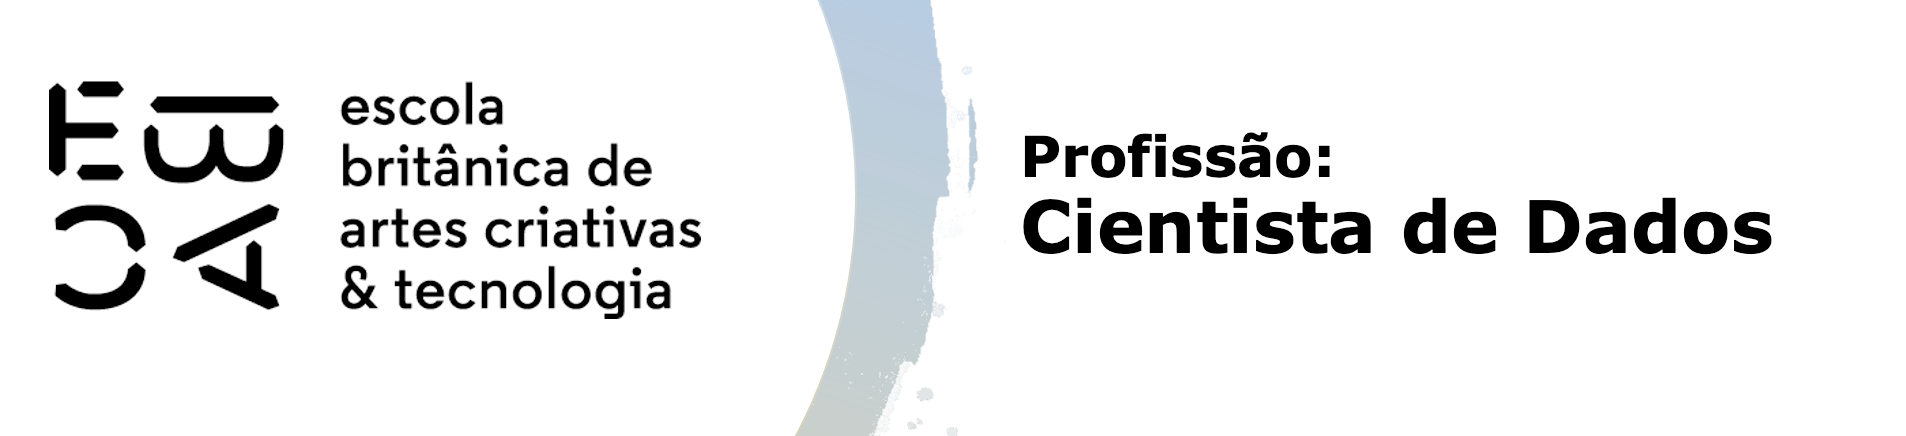

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from pycaret.classification import *
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_feather(r'C:\Users\Joel\Downloads\Data Scientist\Mod 38\credit_scoring.ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
# Converter a coluna data_ref para datetime
df["data_ref"] = pd.to_datetime(df["data_ref"])

# Determinar os três últimos meses na base de dados
ultimos_meses = df["data_ref"].sort_values().unique()[-3:]

# Separar as safras de validação (OOT)
df_oot = df[df["data_ref"].isin(ultimos_meses)]

# Separar as safras de treino
df_treino = df[~df["data_ref"].isin(ultimos_meses)]

# Verificar as dimensões dos conjuntos
df_treino.shape, df_oot.shape

((600000, 15), (150000, 15))

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
# Número total de linhas
num_linhas_total = df.shape[0]

# Número de linhas para cada mês em data_ref
linhas_por_safra = df["data_ref"].value_counts().sort_index()

# Separar variáveis qualitativas e quantitativas
variaveis_qualitativas = df.select_dtypes(include=["object", "category"]).columns.tolist()
variaveis_quantitativas = df.select_dtypes(include=["number"]).drop(columns=["index"]).columns.tolist()

# Estatísticas descritivas para variáveis quantitativas
descritiva_quantitativas = df[variaveis_quantitativas].describe().T

# Estatísticas descritivas para variáveis qualitativas (frequências)
descritiva_qualitativas = {var: df[var].value_counts().to_frame(name="Frequência") for var in variaveis_qualitativas}

# Exibir os resultados
num_linhas_total, linhas_por_safra, descritiva_quantitativas, descritiva_qualitativas

(750000,
 data_ref
 2015-01-01    50000
 2015-02-01    50000
 2015-03-01    50000
 2015-04-01    50000
 2015-05-01    50000
 2015-06-01    50000
 2015-07-01    50000
 2015-08-01    50000
 2015-09-01    50000
 2015-10-01    50000
 2015-11-01    50000
 2015-12-01    50000
 2016-01-01    50000
 2016-02-01    50000
 2016-03-01    50000
 Name: count, dtype: int64,
                           count          mean           std         min  \
 qtd_filhos             750000.0      0.433251      0.739379    0.000000   
 idade                  750000.0     43.804733     11.229868   22.000000   
 tempo_emprego          624043.0      7.748574      6.687455    0.117808   
 qt_pessoas_residencia  750000.0      2.212241      0.903428    1.000000   
 renda                  750000.0  23238.544747  79106.013795  107.670000   
 
                                25%          50%           75%           max  
 qtd_filhos                0.000000     0.000000      1.000000  1.400000e+01  
 idade                

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [7]:
# Garantir que a variável 'mau' está no formato correto (0 e 1)
df['mau'] = df['mau'].astype(int)

# Separar a base entre desenvolvimento e validação out of time (oot)
df['data_ref'] = pd.to_datetime(df['data_ref'])
df = df.sort_values(by='data_ref')

df_dev = df[df['data_ref'] < df['data_ref'].max() - pd.DateOffset(months=2)]
df_oot = df[df['data_ref'] >= df['data_ref'].max() - pd.DateOffset(months=2)]

# Remover colunas que não são preditoras
colunas_explicativas = df.columns.difference(['index', 'data_ref', 'mau'])

# Análise bivariada: quantitativas x `mau`
quantitativas = df_dev[colunas_explicativas].select_dtypes(include=['number'])

# Calcular estatísticas por grupo de inadimplência
estatisticas_quant = quantitativas.groupby(df_dev['mau']).mean().T
estatisticas_quant.columns = ['Não Inadimplente (0)', 'Inadimplente (1)']
estatisticas_quant['Diferença'] = estatisticas_quant['Inadimplente (1)'] - estatisticas_quant['Não Inadimplente (0)']

# Análise bivariada: qualitativas x `mau`
qualitativas = df_dev[colunas_explicativas].select_dtypes(exclude=['number'])
percent_inadimplencia = {
    col: df_dev.groupby(col)['mau'].mean() for col in qualitativas.columns
}
percent_inadimplencia = pd.DataFrame(percent_inadimplencia).T * 100  # Em %

# Exibir resultados
print("\nEstatísticas para variáveis quantitativas:")
print(estatisticas_quant.round(2))

print("\nPercentual de inadimplência por categoria das variáveis qualitativas:")
print(percent_inadimplencia.round(2))


Estatísticas para variáveis quantitativas:
                       Não Inadimplente (0)  Inadimplente (1)  Diferença
idade                                 43.87             42.68      -1.19
qt_pessoas_residencia                  2.21              2.23       0.01
qtd_filhos                             0.43              0.45       0.02
renda                              28588.38           6228.90  -22359.48
tempo_emprego                          7.95              4.64      -3.31

Percentual de inadimplência por categoria das variáveis qualitativas:
                  Aluguel  Assalariado  Bolsista  Casa  Casado  Com os pais  \
educacao              NaN          NaN       NaN   NaN     NaN          NaN   
estado_civil          NaN          NaN       NaN   NaN     6.0          NaN   
posse_de_imovel       NaN          NaN       NaN   NaN     NaN          NaN   
posse_de_veiculo      NaN          NaN       NaN   NaN     NaN          NaN   
sexo                  NaN          NaN       NaN   N

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [9]:
# Garantir que 'mau' está no formato correto
if 'mau' in df.columns:
    df['mau'] = df['mau'].astype(int)

# Converter 'data_ref' para datetime se existir
if 'data_ref' in df.columns:
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df = df.sort_values(by='data_ref')

# Separação entre desenvolvimento e validação out of time (OOT)
if 'data_ref' in df.columns:
    df_dev = df[df['data_ref'] < df['data_ref'].max() - pd.DateOffset(months=2)]
    df_oot = df[df['data_ref'] >= df['data_ref'].max() - pd.DateOffset(months=2)]
else:
    df_dev = df.copy()
    df_oot = pd.DataFrame()  # Se não houver 'data_ref', não há como separar OOT

# Remover colunas não utilizadas se existirem
colunas_para_remover = ['index', 'data_ref']
df_dev = df_dev.drop(columns=[col for col in colunas_para_remover if col in df_dev.columns])
df_oot = df_oot.drop(columns=[col for col in colunas_para_remover if col in df_oot.columns])

# Identificar variáveis categóricas e numéricas
categoricas = df_dev.select_dtypes(include=['object']).columns.tolist()
numericas = df_dev.select_dtypes(include=['number']).columns.difference(['mau']).tolist()

# TRATAMENTO DE VALORES MISSING
df_dev[numericas] = df_dev[numericas].fillna(df_dev[numericas].median())
if not df_oot.empty:
    df_oot[numericas] = df_oot[numericas].fillna(df_dev[numericas].median())  # Aplicar mesmo tratamento na OOT

# TRATAMENTO DE OUTLIERS (IQR)
for col in numericas:
    Q1 = df_dev[col].quantile(0.25)
    Q3 = df_dev[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df_dev[col] = np.clip(df_dev[col], limite_inferior, limite_superior)
    if not df_oot.empty:
        df_oot[col] = np.clip(df_oot[col], limite_inferior, limite_superior)  # Aplicar o mesmo tratamento na OOT

# TRATAMENTO DE CATEGORIAS RARAS
for col in categoricas:
    freq = df_dev[col].value_counts(normalize=True)
    categorias_aceitas = freq[freq > 0.05].index  # Mantém categorias com mais de 5% da base
    df_dev[col] = np.where(df_dev[col].isin(categorias_aceitas), df_dev[col], 'Outros')
    if not df_oot.empty:
        df_oot[col] = np.where(df_oot[col].isin(categorias_aceitas), df_oot[col], 'Outros')

# TRANSFORMAR VARIÁVEIS CATEGÓRICAS EM DUMMIES
df_dev = pd.get_dummies(df_dev, columns=categoricas, drop_first=True, dtype=int)
if not df_oot.empty:
    df_oot = pd.get_dummies(df_oot, columns=categoricas, drop_first=True, dtype=int)

# Garantir que todas as colunas são numéricas
df_dev = df_dev.apply(pd.to_numeric, errors='coerce')
if not df_oot.empty:
    df_oot = df_oot.apply(pd.to_numeric, errors='coerce')

# Garantir que OOT tem as mesmas colunas da base de desenvolvimento
if not df_oot.empty:
    df_oot = df_oot.reindex(columns=df_dev.columns, fill_value=0)

# Atualizar colunas explicativas após transformação de dummies
colunas_explicativas = df_dev.columns.difference(['mau'])

# Criar matriz de preditores (X) e variável resposta (y)
X = df_dev[colunas_explicativas]
y = df_dev['mau']

# Verificar se há colunas ainda com tipo 'object'
print("Colunas não numéricas:", X.select_dtypes(include=['object']).columns.tolist())

# Adicionar constante ao modelo
X = sm.add_constant(X)

# Ajustar modelo de regressão logística
model = sm.Logit(y, X).fit()

# Exibir resumo do modelo
print(model.summary())

Colunas não numéricas: []
Optimization terminated successfully.
         Current function value: 0.206194
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    mau   No. Observations:               600000
Model:                          Logit   Df Residuals:                   599980
Method:                           MLE   Df Model:                           19
Date:                Wed, 19 Mar 2025   Pseudo R-squ.:                  0.1031
Time:                        15:00:32   Log-Likelihood:            -1.2372e+05
converged:                       True   LL-Null:                   -1.3794e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -1.3248      0.17

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [11]:
# Função para calcular o KS
def ks_score(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    ks = max(tpr - fpr)
    return ks

# Função para calcular o Gini
def gini_score(y_true, y_pred_proba):
    auc = roc_auc_score(y_true, y_pred_proba)
    return 2 * auc - 1

# Fazer previsões na base de desenvolvimento
df_dev['score'] = model.predict(sm.add_constant(df_dev[colunas_explicativas]))

# Se existir a base OOT, fazer previsões também
if not df_oot.empty:
    df_oot['score'] = model.predict(sm.add_constant(df_oot[colunas_explicativas]))

# Definir limiar de 0.5 para classificação final
df_dev['predicted'] = (df_dev['score'] >= 0.5).astype(int)
if not df_oot.empty:
    df_oot['predicted'] = (df_oot['score'] >= 0.5).astype(int)

# Avaliação na base de desenvolvimento
acc_dev = accuracy_score(df_dev['mau'], df_dev['predicted'])
ks_dev = ks_score(df_dev['mau'], df_dev['score'])
gini_dev = gini_score(df_dev['mau'], df_dev['score'])

# Avaliação na base out of time (se existir)
if not df_oot.empty:
    acc_oot = accuracy_score(df_oot['mau'], df_oot['predicted'])
    ks_oot = ks_score(df_oot['mau'], df_oot['score'])
    gini_oot = gini_score(df_oot['mau'], df_oot['score'])
else:
    acc_oot, ks_oot, gini_oot = None, None, None

# Exibir resultados
print("📊 Avaliação do Modelo de Credit Scoring\n")
print(f"🔹 Base de Desenvolvimento:")
print(f"   ✅ Acurácia: {acc_dev:.4f}")
print(f"   ✅ KS: {ks_dev:.4f}")
print(f"   ✅ Gini: {gini_dev:.4f}")
print("\n🔹 Base Out of Time (OOT):")
if acc_oot is not None:
    print(f"   ✅ Acurácia: {acc_oot:.4f}")
    print(f"   ✅ KS: {ks_oot:.4f}")
    print(f"   ✅ Gini: {gini_oot:.4f}")
else:
    print("   ⚠️ Base OOT não disponível.")

📊 Avaliação do Modelo de Credit Scoring

🔹 Base de Desenvolvimento:
   ✅ Acurácia: 0.9389
   ✅ KS: 0.3953
   ✅ Gini: 0.5342

🔹 Base Out of Time (OOT):
   ✅ Acurácia: 0.8533
   ✅ KS: 0.3341
   ✅ Gini: 0.4546


## Criar um pipeline utilizando o sklearn pipeline 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [16]:
# Definir variáveis
variaveis_explicativas = df.drop(columns=["index", "data_ref", "mau"])
variaveis_numericas = variaveis_explicativas.select_dtypes(include=['int64', 'float64']).columns
variaveis_categoricas = variaveis_explicativas.select_dtypes(include=['object', 'category']).columns

# Pipeline para variáveis numéricas
pipeline_numerico = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Substitui nulos pela mediana
    ("scaler", StandardScaler())  # Normaliza os dados
])

# Pipeline para variáveis categóricas
pipeline_categorico = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Substitui nulos pelo valor mais frequente
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first"))  # Codifica as categorias
])

# Transformer para aplicar os pipelines
preprocessor = ColumnTransformer([
    ("num", pipeline_numerico, variaveis_numericas),
    ("cat", pipeline_categorico, variaveis_categoricas)
])

# Aplicar o pipeline nos dados
df_processado = preprocessor.fit_transform(df.drop(columns=["index", "data_ref", "mau"]))

# Verificar os dados transformados
print(f"Formato final da base processada: {df_processado.shape}")

Formato final da base processada: (750000, 25)


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [22]:
def tratar_outliers(df, variaveis_numericas, metodo="iqr"):
    df_limpo = df.copy()

    for col in variaveis_numericas:
        if metodo == "iqr":
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR

            # Opção 1: Remover outliers
            df_limpo = df_limpo[(df[col] >= limite_inferior) & (df[col] <= limite_superior)]
        
            # Opção 2: Winsorizar (substituir valores extremos)
            # df_limpo[col] = np.where(df_limpo[col] < limite_inferior, limite_inferior, df_limpo[col])
            # df_limpo[col] = np.where(df_limpo[col] > limite_superior, limite_superior, df_limpo[col])

        elif metodo == "zscore":
            media = df[col].mean()
            desvio = df[col].std()
            df_limpo = df_limpo[np.abs((df[col] - media) / desvio) < 3]

    return df_limpo

# Aplicar tratamento
df_sem_outliers = tratar_outliers(df, variaveis_numericas, metodo="iqr")

# Verificar quantas linhas foram removidas
print(f"Linhas antes: {df.shape[0]}, Linhas depois: {df_sem_outliers.shape[0]}")

Linhas antes: 750000, Linhas depois: 531682


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [27]:
# Ajustar o modelo com todas as variáveis
X_train_const = sm.add_constant(X)
modelo = sm.Logit(y, X_train_const).fit()

# Exibir p-valores
print(modelo.pvalues)

# Selecionar variáveis com p-valor < 0.05
variaveis_significativas = modelo.pvalues[modelo.pvalues < 0.05].index.tolist()
print("Variáveis selecionadas:", variaveis_significativas)

Optimization terminated successfully.
         Current function value: 0.206194
         Iterations 9
const                          9.091943e-14
educacao_Outros                2.707168e-01
educacao_Superior completo     8.536908e-05
estado_civil_Outros            2.925525e-01
estado_civil_Separado          7.528257e-01
estado_civil_Solteiro          5.193832e-01
estado_civil_União             1.894506e-02
idade                          5.379514e-01
posse_de_imovel_S              3.781317e-10
posse_de_veiculo_S             1.055600e-02
qt_pessoas_residencia          4.686475e-01
qtd_filhos                     4.655962e-01
renda                          0.000000e+00
sexo_M                         3.193848e-17
tempo_emprego                  1.869633e-27
tipo_renda_Empresário          8.114901e-04
tipo_renda_Outros              6.403690e-01
tipo_renda_Pensionista         6.308772e-05
tipo_renda_Servidor público    3.116966e-01
tipo_residencia_Outros         2.466460e-01
dtype: float64
Var

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [31]:
# Remover variáveis não explicativas
X_modelagem = X.drop(columns=['index', 'data_ref'], errors='ignore')

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_modelagem)

# Aplicar PCA para 5 componentes principais
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Exibir a variância explicada por cada componente
print("Variância explicada por componente:", pca.explained_variance_ratio_)
print("Variância total explicada:", sum(pca.explained_variance_ratio_))

# Transformar os dados para modelagem
X_train_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

Variância explicada por componente: [0.14810555 0.09318416 0.08326187 0.06494533 0.06316514]
Variância total explicada: 0.4526620568494885


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

<span style="color: red;">As variáveis categóricas já foram transformadas em dummies no desenvolvimento do modelo de regressão logística.</span>

In [39]:
df.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [42]:
# Criar um transformer para remoção de outliers usando IQR
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.5):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_out = X.copy()
        for col in X_out.select_dtypes(include=['number']).columns:
            Q1 = X_out[col].quantile(0.25)
            Q3 = X_out[col].quantile(0.75)
            IQR = Q3 - Q1
            lim_inf = Q1 - self.threshold * IQR
            lim_sup = Q3 + self.threshold * IQR
            X_out = X_out[(X_out[col] >= lim_inf) & (X_out[col] <= lim_sup)]
        return X_out

# Separar colunas numéricas e categóricas
num_features = ['renda', 'idade', 'tempo_emprego', 'qtd_filhos', 'qt_pessoas_residencia'] 
cat_features = ['posse_de_veiculo', 'sexo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

# Criar transformações separadas para cada tipo de dado
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3))
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', dtype=int))
])

# Combinar os pré-processamentos em um ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Criar o pipeline final
pipeline = Pipeline([
    ('outlier_removal', OutlierRemover()),  # Remover outliers
    ('preprocessor', preprocessor)  # Aplicar transformações
])

# Carregar a base de dados
df = pd.read_csv(r'C:\Users\Joel\Downloads\Data Scientist\Mod 38\credit_scoring.csv')

# Aplicar o pipeline nos dados
X_processed = pipeline.fit_transform(df)

# Exibir o resultado
print(X_processed.shape)

(525223, 23)


### Treinar um modelo de regressão logistica com o resultado

In [74]:
# ---------------------------
# 1. Definir o transformer de remoção de outliers
# ---------------------------
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=2.0):  # Alterado de 1.5 para 2.0
        self.threshold = threshold

    def fit(self, X, y=None):
        self.limits_ = {}
        for col in X.select_dtypes(include=['number']).columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lim_inf = Q1 - self.threshold * IQR
            lim_sup = Q3 + self.threshold * IQR
            self.limits_[col] = (lim_inf, lim_sup)
        return self

    def transform(self, X):
        X_out = X.copy()
        mask = np.ones(len(X_out), dtype=bool)
        for col, (lim_inf, lim_sup) in self.limits_.items():
            mask &= (X_out[col] >= lim_inf) & (X_out[col] <= lim_sup)

        X_filtered = X_out.loc[mask].reset_index(drop=True)

        # Se remover todos os dados, retorna os dados originais sem remoção de outliers
        if X_filtered.shape[0] == 0:
            print("⚠ Nenhuma amostra restante após remoção de outliers! Mantendo os dados originais...")
            return X_out.reset_index(drop=True)
        
        return X_filtered

# ---------------------------
# 2. Configurar as colunas para o pré-processamento
# ---------------------------
num_features = ['renda', 'idade', 'tempo_emprego', 'qtd_filhos', 'qt_pessoas_residencia'] 
cat_features = ['posse_de_veiculo', 'sexo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

# Pipeline para variáveis numéricas: imputação, escalonamento e PCA
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3))
])

# Pipeline para variáveis categóricas: imputação e one-hot encoding
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', dtype=int))
])

# Combinar as transformações em um ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Pipeline completo: primeiro remove outliers, depois aplica as transformações
full_pipeline = Pipeline([
    ('outlier_removal', OutlierRemover()),
    ('preprocessor', preprocessor)
])

# ---------------------------
# 3. Carregar os dados e separar target e features
# ---------------------------
#df = pd.read_csv(r'C:\Users\Joel\Downloads\Data Scientist\Mod 38\credit_scoring.csv')

# Converter datas para formato adequado (se existirem colunas de datas)
for col in df.select_dtypes(include=['object']):
    try:
        df[col] = pd.to_datetime(df[col])
    except:
        pass  # Se a conversão falhar, significa que não é uma data válida

# Redefinir os índices (para garantir alinhamento)
#df = df.reset_index(drop=True)

# Separar target e features
y = df['mau']
X = df.drop(columns=['mau'])

# ---------------------------
# 4. Aplicar o pipeline e alinhar o target
# ---------------------------
X_no_outliers = full_pipeline.named_steps['outlier_removal'].fit_transform(X)
print(f"Número de amostras após remoção de outliers: {X_no_outliers.shape[0]}")

# Verificar se `X_no_outliers` ficou vazio
if X_no_outliers.shape[0] == 0:
    print("⚠ Nenhuma amostra restante! Mantendo os dados originais...")
    X_no_outliers = X.copy()

# Obter os índices das linhas que passaram na remoção de outliers
indices_validos = X_no_outliers.index
y_clean = y.loc[indices_validos].reset_index(drop=True)

# Agora, aplicar o pré-processamento (imputação, escalonamento, PCA e criação de dummies)
X_processed = full_pipeline.named_steps['preprocessor'].fit_transform(X_no_outliers)

# Garantir que os dados não ficaram vazios após pré-processamento
if X_processed.shape[0] == 0:
    raise ValueError("Erro crítico: Nenhuma amostra disponível após pré-processamento. Revise os filtros aplicados.")

# ---------------------------
# 5. Dividir os dados e treinar o modelo de regressão logística
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_clean, test_size=0.3, random_state=42)

# Treinar o modelo de regressão logística (aumentando max_iter se necessário)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Fazer predições e avaliar o modelo
y_pred = logreg.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))


Número de amostras após remoção de outliers: 556331
Acurácia: 0.9416357100059917

Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.94      1.00      0.97    157159
        True       0.00      0.00      0.00      9741

    accuracy                           0.94    166900
   macro avg       0.47      0.50      0.48    166900
weighted avg       0.89      0.94      0.91    166900


Matriz de Confusão:
 [[157159      0]
 [  9741      0]]


In [72]:
X_processed

array([[-1.44823896, -0.71931848, -0.11158459, ...,  0.        ,
         0.        ,  0.        ],
       [-0.38238649, -1.03297093,  0.38735702, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.04854825, -1.05658266, -0.35363798, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.37416259,  0.67145353, -1.39481617, ...,  0.        ,
         0.        ,  0.        ],
       [-2.11814235,  0.73443229, -1.1953422 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.33769989,  0.915073  , -1.25672309, ...,  0.        ,
         0.        ,  0.        ]])

### Salvar o pickle file do modelo treinado

In [76]:
import pickle

pickle.dump(logreg, open('model_final.pkl', 'wb'))

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [70]:
from pycaret.classification import *


# Carregar os dados (exemplo)
df = pd.read_feather(r'C:\Users\Joel\Downloads\Data Scientist\Mod 38\credit_scoring.ftr')

# Inicializar o ambiente definindo o target (supondo que a coluna de inadimplência se chame 'mau')
exp = setup(data=df, target='mau')

# Agora é possível listar os modelos disponíveis:
models()

Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
xgboost         Extreme Gradient Boosting   
lightgbm  Light Gradient Boosting Machine   
dummy                    Dummy Classifier   

                                                  Reference  Turbo  
ID                                                                  
lr        sklearn.linear_model._logistic.LogisticRegression   True  
knn       sklearn.neighbors._classification.KNeighborsCl...   True  
nb                           sklearn.naive_bayes.GaussianNB   True  
dt             sklearn.tree._classes.DecisionTreeClassifier   True  
svm       sklearn.linear_model._stochastic_gradient.SGDC...   True  
rbfsvm                             sklearn.svm._classes.SVC  False  
gpc       sklearn.gaussian_process._gpc.GaussianProcessC...  False  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
ridge           sklearn.linear_model._ridge.RidgeClassifier   True  
rf          sklearn.ensemble._forest.RandomForestClassifier   True  
qda       sklearn.discriminant_analysis.QuadraticDiscrim...   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostClas...   True  
gbc         sklearn.ensemble._gb.GradientBoostingClassifier   True  
lda       sklearn.discriminant_analysis.LinearDiscrimina...   True  
et            sklearn.ensemble._forest.ExtraTreesClassifier   True  
xgboost                       xgboost.sklearn.XGBClassifier   True  
lightgbm                    lightgbm.sklearn.LGBMClassifier   True  
dummy                         sklearn.dummy.DummyClassifier   True

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

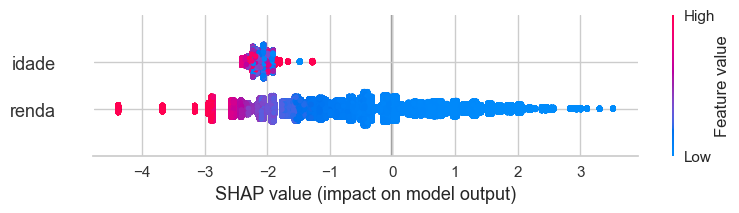

In [71]:
# 📌 Remover colunas que não são explicativas
df = df.drop(columns=['index', 'data_ref'])  

# 📌 Padronizar os nomes das categorias removendo espaços e acentos
df = df.apply(lambda x: x.str.replace(' ', '_') if x.dtype == 'object' else x)

# 📌 Inicializar o setup do PyCaret
clf = setup(
    data=df, 
    target='mau',  # Variável alvo
    ignore_features=['index', 'data_ref'],  # Não usar indexadores
    normalize=True,  # Normalização das variáveis numéricas
    fix_imbalance=True,  # Ajusta desbalanceamento da classe
    remove_outliers=True,  # Remove outliers automaticamente
    feature_selection=True,  # Seleção automática de variáveis
    verbose=False,  # Substitui o argumento 'silent'
    session_id=42  # Para reprodutibilidade
)

# 📌 Treinar o modelo LightGBM
modelo = create_model('lightgbm')

# 📌 Ajustar hiperparâmetros automaticamente
modelo_tunado = tune_model(modelo)

# 📌 Avaliação do modelo
evaluate_model(modelo_tunado)

# 📌 Interpretabilidade (SHAP)
interpret_model(modelo_tunado)



### Salvar o arquivo do modelo treinado

In [74]:
# 📌 Geração do pipeline final e exportação
final_model = finalize_model(modelo_tunado)
save_model(final_model, 'model_final_treinado')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.